In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import json
import numpy as np

In [2]:
# EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'
EXPERIMENT_DIR = '/Users/darylwilding-mcbride/Downloads/experiments/dwm-test'


In [3]:
EXTRACTED_FEATURES_DIR = "{}/extracted-features".format(EXPERIMENT_DIR)
EXTRACTED_FEATURES_DB_NAME = "{}/extracted-features.sqlite".format(EXTRACTED_FEATURES_DIR)

In [4]:
db_conn = sqlite3.connect(EXTRACTED_FEATURES_DB_NAME)
sequences_df = pd.read_sql_query('select sequence,charge,file_idx,isotope_intensities_l from features where batch==\'1to1\' and number_of_runs_extracted==10', db_conn)
db_conn.close()

In [5]:
sequence_charge_l = []
for group_name,group_df in sequences_df.groupby(['sequence','charge']):
    sequence_charge_l.append((group_name[0], group_name[1]))
sequence_charge_df = pd.DataFrame(sequence_charge_l, columns=['sequence','charge'])

In [6]:
sequences_for_analysis_df = pd.merge(sequence_charge_df.sample(n=1000), sequences_df, how='left', left_on=['sequence','charge'], right_on=['sequence','charge'])

In [7]:
# expand the raw points for the monoisotope
# index 4 of isotope_intensities_l is the raw points for each isotope
sequences_for_analysis_df['isotope_raw_points'] = sequences_for_analysis_df.apply(lambda row: [pd.DataFrame(d[4], columns=['mz','scan','frame_id','retention_time_secs','intensity']).to_dict('records') for d in json.loads(row.isotope_intensities_l)], axis=1)


#### prototyping area

In [8]:
sequences_for_analysis_df.sample(n=5)

,sequence,charge,file_idx,isotope_intensities_l,isotope_raw_points
3716,LHDLYWQAMK,2,10,"[[1817.0, false, 1817.0, false, [[652.82582296...","[[{'mz': 652.8258229630558, 'scan': 673.0, 'fr..."
7915,LVINTEEVFRPYAK,2,2,"[[2138.0, false, 2138.0, false, [[839.95920336...","[[{'mz': 839.9592033633032, 'scan': 300.0, 'fr..."
2618,DVEDFLSPLLGK,2,11,"[[3213.0, false, 3213.0, false, [[666.85573593...","[[{'mz': 666.8557359362198, 'scan': 695.0, 'fr..."
5765,GDADQASNILASFGLSAR,3,2,"[[777.0, false, 777.0, false, [[598.2974919485...","[[{'mz': 598.2974919485489, 'scan': 827.0, 'fr..."
9981,FLEETNCLYAAEGQR,2,15,"[[2813.0, false, 2813.0, false, [[900.91408700...","[[{'mz': 900.9140870007707, 'scan': 393.0, 'fr..."


In [9]:
selected_sequence = sequences_for_analysis_df.loc[9292]

In [10]:
isotopes_l = []
for isotope_idx,isotope in enumerate(selected_sequence.isotope_raw_points):
    isotope_df = pd.DataFrame(isotope)
    # fix up some types
    isotope_df.frame_id = isotope_df.frame_id.astype(int)
    isotope_df.scan = isotope_df.scan.astype(int)
    isotope_df.intensity = isotope_df.intensity.astype(int)
    # keep track of which isotope is which
    isotope_df['isotope_idx'] = isotope_idx
    isotopes_l.append(isotope_df)
# join the list of dataframes into a single dataframe
isotopes_df = pd.concat(isotopes_l, axis=0, sort=False)
monoisotope_df = isotopes_df[isotopes_df.isotope_idx == 0]

In [11]:
sorted(monoisotope_df.frame_id.unique())

[2756,
 2761,
 2766,
 2771,
 2776,
 2781,
 2786,
 2791,
 2796,
 2801,
 2806,
 2811,
 2816,
 2821]

In [12]:
top_ccs_proportion_to_include = 0.8
top_rt_proportion_to_include = 1.0

In [13]:
# find the maximum intensity by scan in each frame
frame_ccs_cutoffs = []
for group_name,group_df in monoisotope_df.groupby(['frame_id']):
    max_intensity = group_df.intensity.max()
    intensity_cutoff = (1.0 - top_ccs_proportion_to_include) * max_intensity
    frame_ccs_cutoffs.append((group_name, intensity_cutoff))

In [14]:
frames_l = []
for ccs_cutoff in frame_ccs_cutoffs:
    frame_df = monoisotope_df[(monoisotope_df.frame_id == ccs_cutoff[0]) & (monoisotope_df.intensity >= ccs_cutoff[1])]
    frames_l.append(frame_df)
monoisotope_ccs_cutoff_df = pd.concat(frames_l, axis=0, sort=False)



In [15]:
rt_flattened_monoisotope_ccs_cutoff_df = monoisotope_ccs_cutoff_df.groupby(['frame_id','retention_time_secs'], as_index=False).intensity.sum()


In [16]:
# find the maximum intensity by RT
max_rt_intensity = rt_flattened_monoisotope_ccs_cutoff_df.intensity.max()
rt_intensity_cutoff = (1.0 - top_rt_proportion_to_include) * max_rt_intensity

In [17]:
rt_df = rt_flattened_monoisotope_ccs_cutoff_df[rt_flattened_monoisotope_ccs_cutoff_df.intensity >= rt_intensity_cutoff]


In [18]:
intensity = rt_df.intensity.sum()
intensity

35078

In [19]:
result = {}
result['name'] = 'ccs-{}-rt-{}'.format(top_ccs_proportion_to_include, top_rt_proportion_to_include)
result['preprocessing'] = 'raw'
result['top_ccs_proportion_to_include'] = top_ccs_proportion_to_include
result['top_rt_proportion_to_include'] = top_rt_proportion_to_include
result['intensity'] = intensity

In [20]:
result

{'name': 'ccs-0.8-rt-1.0',
 'preprocessing': 'raw',
 'top_ccs_proportion_to_include': 0.8,
 'top_rt_proportion_to_include': 1.0,
 'intensity': 35078}

#### visualise the CCS cutoffs

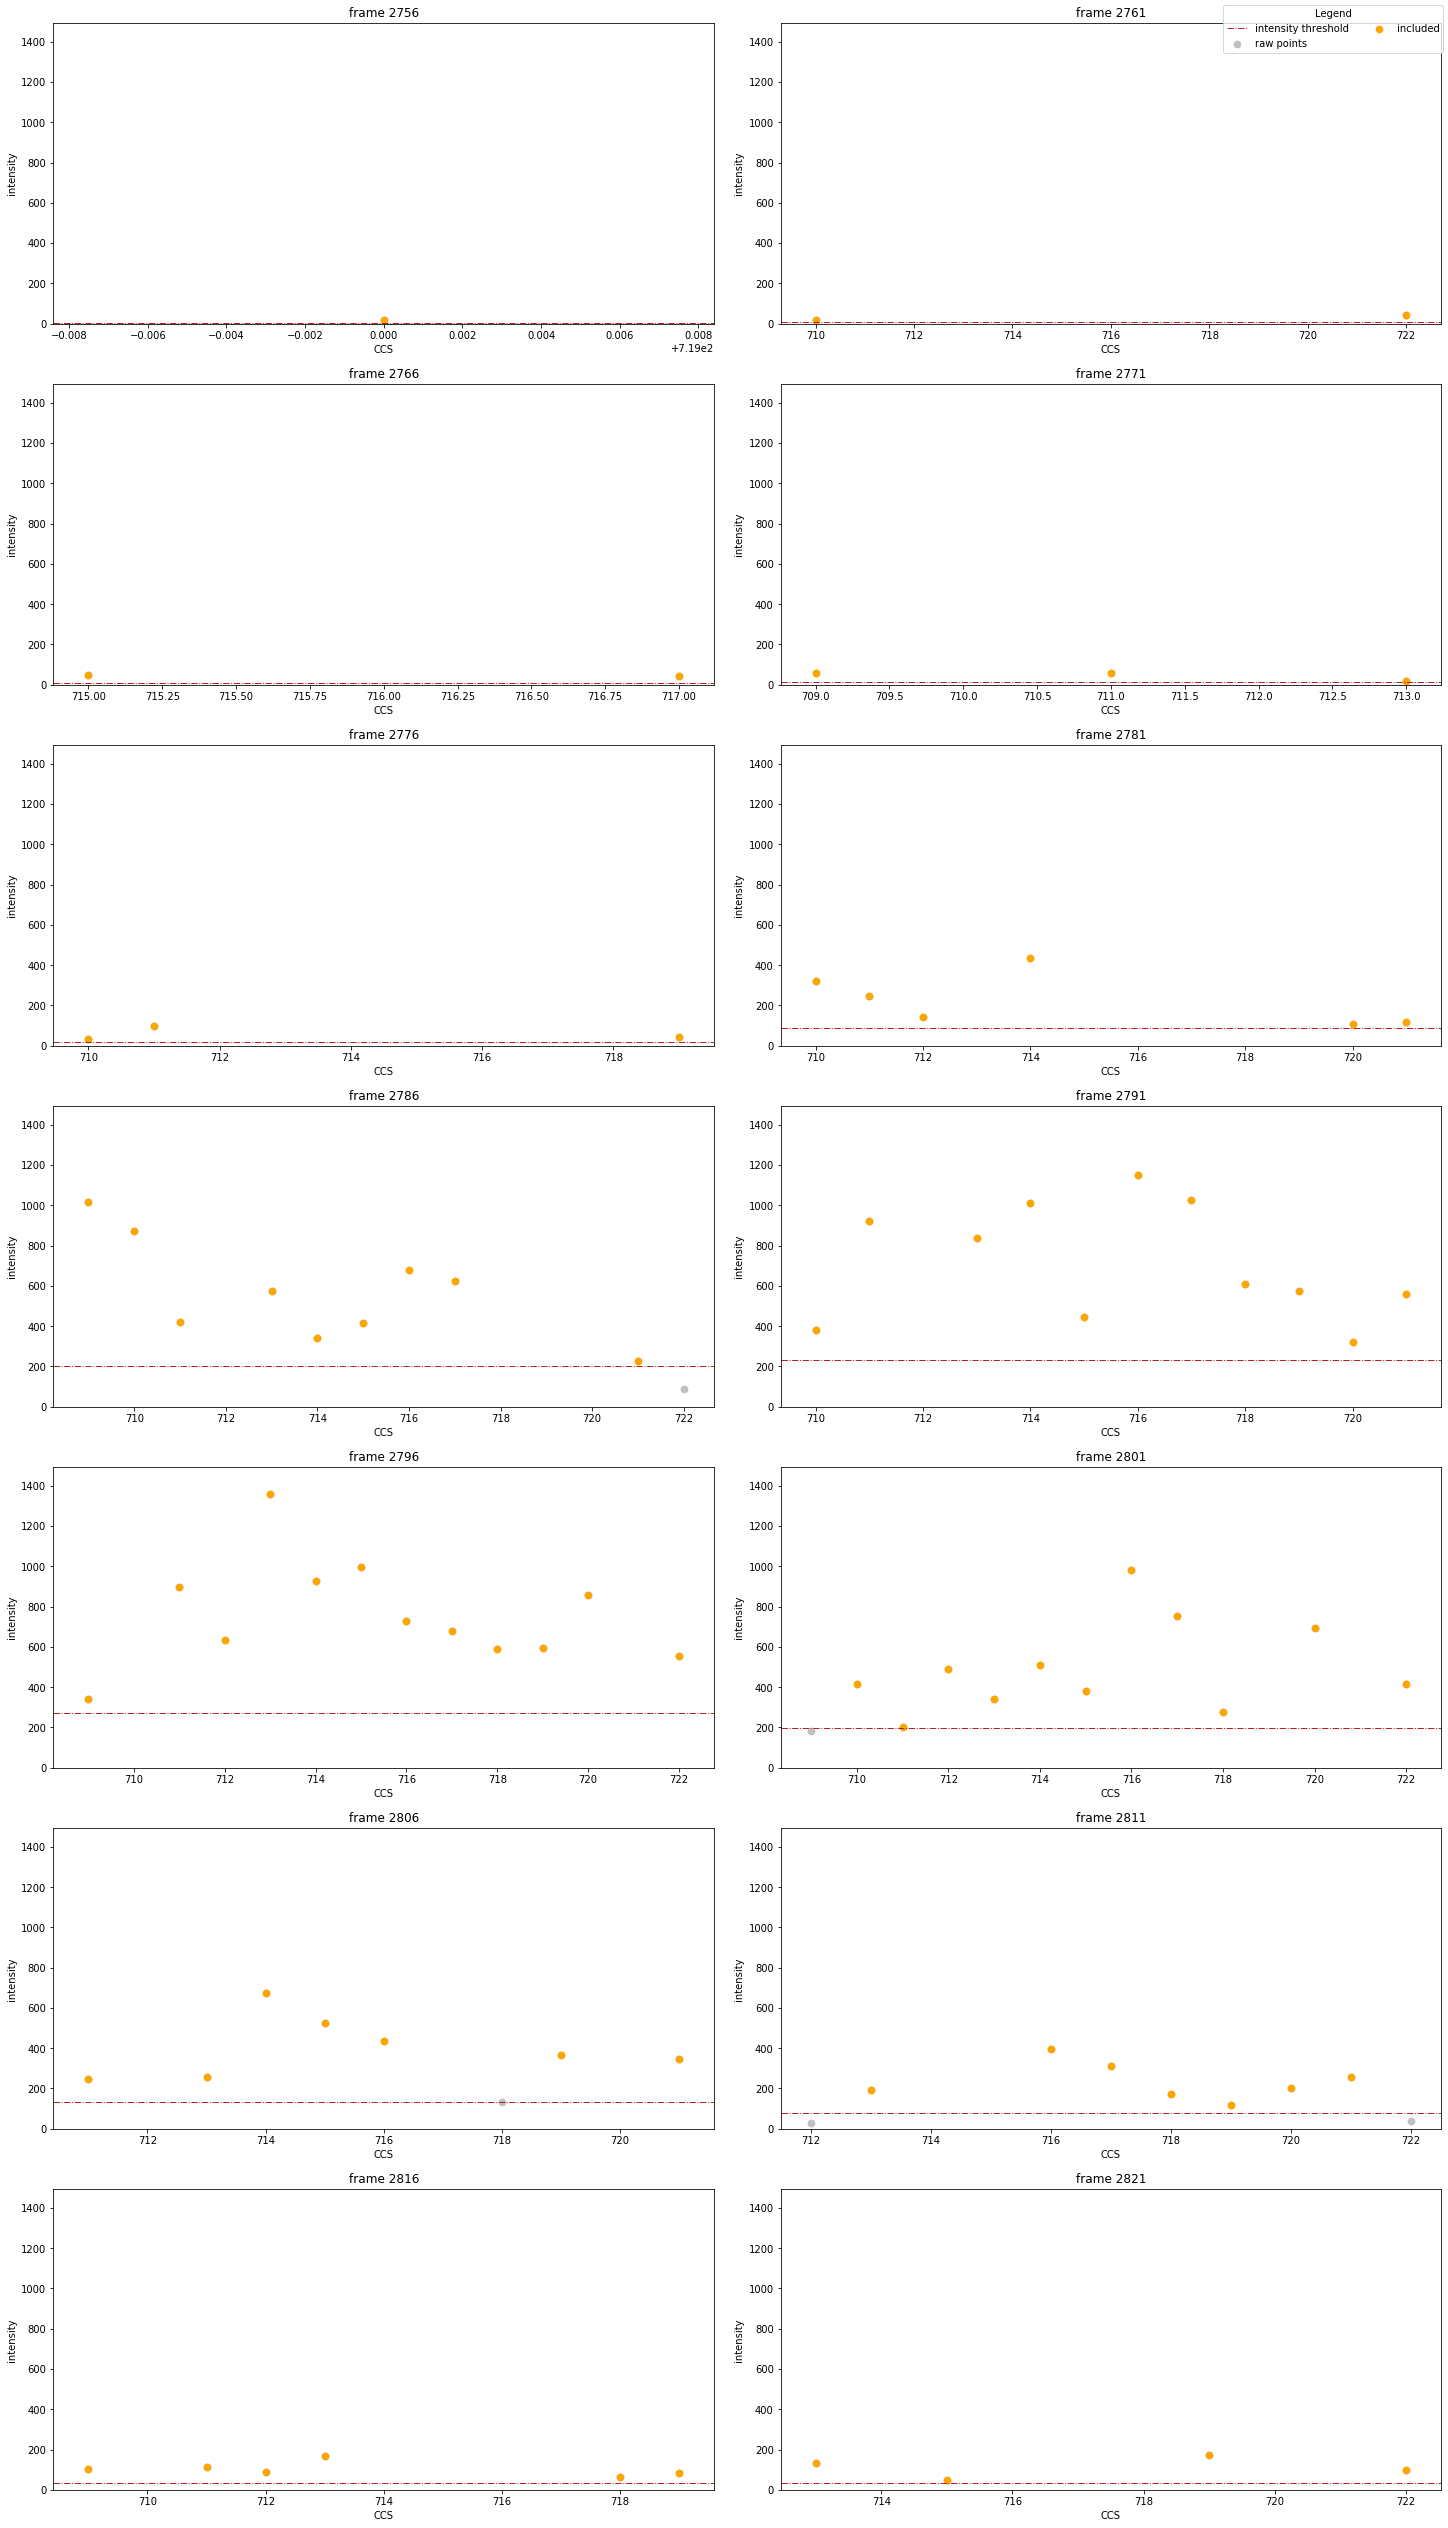

In [21]:
number_of_frames = len(monoisotope_df.frame_id.unique())
max_intensity = monoisotope_df.intensity.max()
number_of_rows = int(number_of_frames/2) + (number_of_frames % 2)

f, axarr = plt.subplots(nrows=number_of_rows, ncols=2, constrained_layout=True)
f.set_figheight(number_of_rows * 5)
f.set_figwidth(20)
# f.suptitle('extracted feature identified as sequence {}, charge {} in batch {}\n\n\n\n'.format(selected_sequence, selected_sequence_charge, selected_batch), fontsize=18)

max_labels = 0
for idx,ccs_cutoff in enumerate(frame_ccs_cutoffs):
    frame_df = monoisotope_df[(monoisotope_df.frame_id == ccs_cutoff[0])]
    frame_includes_df = monoisotope_ccs_cutoff_df[(monoisotope_ccs_cutoff_df.frame_id == ccs_cutoff[0])]

    r = int(idx / 2)
    c = idx % 2

    ax = axarr[r,c]  # row, column
    ax.set_title('frame {}'.format(ccs_cutoff[0]))
    
    ax.scatter(frame_df.scan, frame_df.intensity, marker='o', color='silver', lw=0, s=60, alpha=1.0, label='raw points')
    ax.scatter(frame_includes_df.scan, frame_includes_df.intensity, marker='o', color='orange', lw=0, s=60, alpha=1.0, label='included')
    
    ax.axhline(ccs_cutoff[1], color='firebrick', lw=1.0, ls='-.', label='intensity threshold')

    # set up axes
    ax.set_ylim((0,max_intensity*1.1))
    ax.set_xlabel('CCS')
    ax.set_ylabel('intensity')

    # make a legend from all possible labels
    handles, labels = ax.get_legend_handles_labels()
    if len(labels) > max_labels:
        max_labels = len(labels)
        superset_handles = handles
        superset_labels = labels

f.legend(superset_handles, superset_labels, loc='upper right', ncol=2, title="Legend", fancybox=True)

plt.show()    

#### visualise the RT cutoff

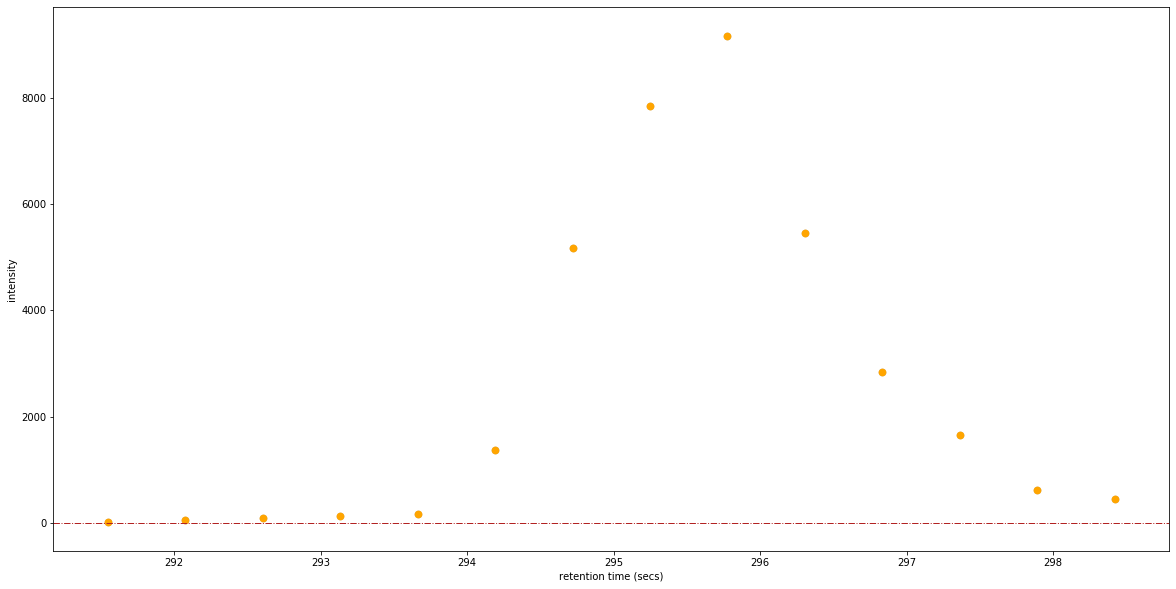

In [22]:
# visualise the RT cutoffs
f, ax = plt.subplots()
f.set_figheight(10)
f.set_figwidth(20)
# f.suptitle('extracted feature identified as sequence {}, charge {} in batch {}\n\n\n\n'.format(selected_sequence, selected_sequence_charge, selected_batch), fontsize=18)

# ax.set_title('frame {}'.format(ccs_cutoff[0]))

ax.scatter(rt_flattened_monoisotope_ccs_cutoff_df.retention_time_secs, rt_flattened_monoisotope_ccs_cutoff_df.intensity, marker='o', color='silver', lw=0, s=60, alpha=1.0, label='raw points')
ax.scatter(rt_df.retention_time_secs, rt_df.intensity, marker='o', color='orange', lw=0, s=60, alpha=1.0, label='included')

ax.axhline(rt_intensity_cutoff, color='firebrick', lw=1.0, ls='-.', label='intensity threshold')

# set up axes
ax.set_xlabel('retention time (secs)')
ax.set_ylabel('intensity')

plt.show()    